In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [2]:
df = pd.read_csv("C:\\Users\\Priyal\\Downloads\\Fraud.csv")

In [3]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


<Axes: xlabel='type', ylabel='count'>

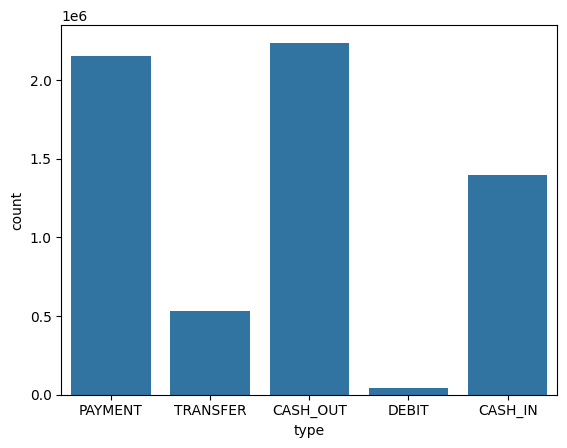

In [4]:
sns.countplot(x='type', data=df)

In [ ]:
DATA PREPROCESSING

In [15]:
#Missing Values
df.dropna(inplace=True)

In [23]:
#Remove outliers
z_scores = np.abs(zscore(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]))
df_new= df[(z_scores < 3).all(axis=1)] 

In [24]:
#dropping highly correlated columns
numeric_cols = df_new.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
df_new = df_new.drop(to_drop, axis=1)
print(f"Dropped columns: {to_drop}")

Dropped columns: ['newbalanceOrig', 'newbalanceDest']


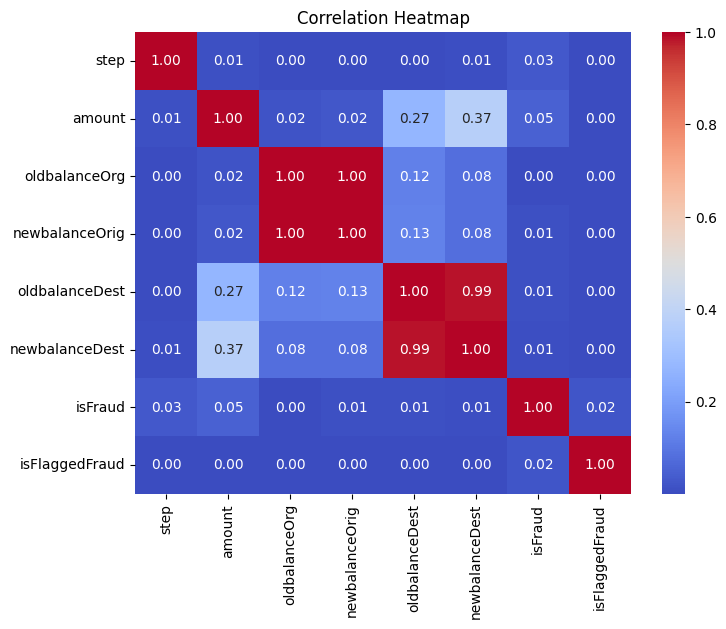

In [25]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [26]:
print(df_new.head())

   step      type    amount     nameOrig  oldbalanceOrg     nameDest  \
0     1   PAYMENT   9839.64  C1231006815       170136.0  M1979787155   
1     1   PAYMENT   1864.28  C1666544295        21249.0  M2044282225   
2     1  TRANSFER    181.00  C1305486145          181.0   C553264065   
3     1  CASH_OUT    181.00   C840083671          181.0    C38997010   
4     1   PAYMENT  11668.14  C2048537720        41554.0  M1230701703   

   oldbalanceDest  isFraud  isFlaggedFraud  
0             0.0        0               0  
1             0.0        0               0  
2             0.0        1               0  
3         21182.0        1               0  
4             0.0        0               0  


In [27]:
X = df_new.drop(['isFraud','type','nameOrig', 'nameDest'], axis=1)
y = df_new['isFraud']

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [29]:
# Calculating scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [ ]:
HYPERPARAMETER TUNING

In [30]:
#hyperparameter tuning
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    eta=0.07,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_lambda=10,
    reg_alpha=2,
    n_estimators=500,
    scale_pos_weight=10,
    early_stopping_rounds=30,
    random_state=42
)

In [31]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-auc:0.97486
[1]	validation_0-auc:0.96346
[2]	validation_0-auc:0.95826
[3]	validation_0-auc:0.97575
[4]	validation_0-auc:0.97780
[5]	validation_0-auc:0.97521
[6]	validation_0-auc:0.97667
[7]	validation_0-auc:0.97447
[8]	validation_0-auc:0.97586
[9]	validation_0-auc:0.97716
[10]	validation_0-auc:0.98036
[11]	validation_0-auc:0.98146
[12]	validation_0-auc:0.98191
[13]	validation_0-auc:0.98291
[14]	validation_0-auc:0.98496
[15]	validation_0-auc:0.98616
[16]	validation_0-auc:0.98606
[17]	validation_0-auc:0.98699
[18]	validation_0-auc:0.98791
[19]	validation_0-auc:0.98817
[20]	validation_0-auc:0.98791
[21]	validation_0-auc:0.98747
[22]	validation_0-auc:0.98806
[23]	validation_0-auc:0.98868
[24]	validation_0-auc:0.98836
[25]	validation_0-auc:0.98859
[26]	validation_0-auc:0.98829
[27]	validation_0-auc:0.98792
[28]	validation_0-auc:0.98818
[29]	validation_0-auc:0.98781
[30]	validation_0-auc:0.98736
[31]	validation_0-auc:0.98816
[32]	validation_0-auc:0.98775
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=30,
              enable_categorical=False, eta=0.07, eval_metric='auc',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
MODEL EVALUATION

In [34]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [35]:
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9992
ROC AUC: 0.9979


In [36]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1825231
           1       0.58      0.78      0.67      1946

    accuracy                           1.00   1827177
   macro avg       0.79      0.89      0.83   1827177
weighted avg       1.00      1.00      1.00   1827177



In [37]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1824154    1077]
 [    431    1515]]


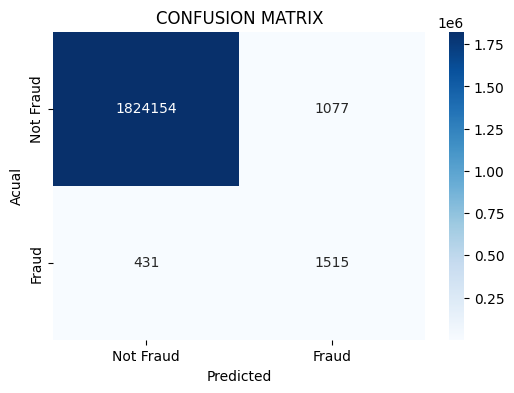

In [38]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Acual')
plt.title('CONFUSION MATRIX')
plt.show()